# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



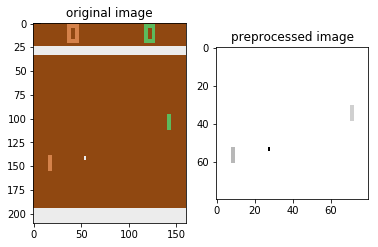

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
        ########
        ## 
        ## Modify your neural network
        ##
        ########
        
        # 80x80x2 to 39x39x4
        self.conv1 = nn.Conv2d(2, 4, kernel_size=4, stride=2, bias=False)
        # 80x80x2 to 12x12x8
        self.conv2 = nn.Conv2d(4, 8, kernel_size=6, stride=3)
        
        self.size=12*12*8
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        
        # Sigmoid to
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        ########
        ## 
        ## Modify your neural network
        ##
        ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))


# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards $R_{t}^{\rm future}$
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    # normalize future rewards over all the parallel agents
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    # calculate the ratio \frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}
    # make sure that the no_grad is enabled when performing the division
    with torch.no_grad():
        ratio = new_probs/old_probs
    
    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # add an entropy bonus to ensure sufficient exploratuion
    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    # L_t^{CLIP+S} = E_t[L_t^CLIP(\theta) + c_2 S[\pi_{\theta(s_t)}]]
    return torch.mean(clipped_surrogate + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # Optimize surrogate L wrt \theta with K epochs
    # where is minibatch?
    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # The 'for action==1, 2, ... N do' is implicit in surrogate func
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Episode: 20, score: -12.875000
[-12. -12. -16.  -9. -16. -11. -13. -14.]


Episode: 40, score: -14.500000
[-12. -16. -16. -14. -13. -14. -16. -15.]


Episode: 60, score: -12.250000
[-16.  -9. -16.  -7. -12.  -7. -16. -15.]


Episode: 80, score: -14.000000
[-16. -15. -11. -16. -11. -17. -12. -14.]


Episode: 100, score: -12.750000
[-13. -15. -14. -14. -10. -13.  -9. -14.]


Episode: 120, score: -12.625000
[-12. -16. -10.  -9. -15. -12. -16. -11.]


Episode: 140, score: -11.375000
[ -5. -13. -14. -10. -12. -12. -14. -11.]


Episode: 160, score: -12.375000
[-12. -14. -14. -15. -12. -12. -11.  -9.]


Episode: 180, score: -10.500000
[-13.  -8.  -5. -13. -11.  -7. -14. -13.]


Episode: 200, score: -7.750000
[ -8.  -6.  -2. -12.  -6. -11.  -6. -11.]


Episode: 220, score: -5.500000
[-11. -12.  -5.  -2.  -4.  -5.  -1.  -4.]


Episode: 240, score: -4.875000
[-6. -6. -6. -7. -2. -5. -4. -3.]


Episode: 260, score: -3.875000
[-6. -3. -1. -2. -6. -9. -3. -1.]


Episode: 280, score: -2.875000
[-5. -1. -7. -2. -1. -1. -5. -1.]


Episode: 300, score: -0.875000
[-1.  0. -2. -1. -1. -1. -1.  0.]


Episode: 320, score: -1.750000
[-3. -6. -1. -1. -1.  0. -1. -1.]


Episode: 340, score: -1.125000
[-1. -3. -1. -1. -1.  0. -1. -1.]


Episode: 360, score: -0.875000
[ 0. -1. -1. -1. -1. -1. -1. -1.]


Episode: 380, score: -1.125000
[-1. -1. -1. -2. -1. -1. -1. -1.]


Episode: 400, score: -1.000000
[-2.  0. -1. -1. -1. -1. -1. -1.]


Episode: 420, score: -1.500000
[-1. -1.  0. -1. -6. -1. -1. -1.]


Episode: 440, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 460, score: -1.625000
[ 0. -1. -3. -3. -1. -3. -1. -1.]


Episode: 480, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 500, score: -1.125000
[-1. -1. -1. -1. -1. -2. -1. -1.]


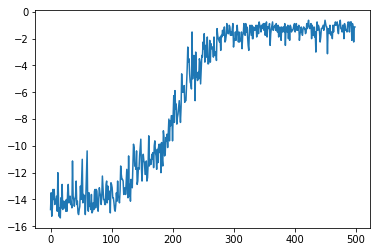

In [8]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 